### 0. Load data

In [1]:
import os
import numpy as np
import torch
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

'''
How data loading works in this project:
* We assume the npy will be sufficient to load into memory
* latent composition:
    concat_tensor = torch.cat([
        x_info['kp'], # 63
        x_info['exp'], # 63,
        x_info['t'], # 3
        x_info['pitch'], # 1
        x_info['yaw'], # 1
        x_info['roll'], # 1
        x_info['scale'], # 1
    ], dim=1)
    
    for person_feat
     - kp single batch avg used for v1. exp keep the same, use global avg scale. t and rot will be subtracted in subsequent frames, 
     - so we can ignore t and rot for now
    for training data
     - use individual kp, exp, subtract dominant t and rot, use global scale
    
    

1. Load both audio and motion latent from the npy files with load_npy_files
    2.  Motion latent is processed to have a window of 65 frames with 10 frames overlap
    2.1 The rotation and translation are frontalized 
3.  The processed data is then loaded into a custom dataset class for random sampling
'''

'''
Part 1: Load and process the npy files
'''
def load_and_process_pair(audio_file, motion_file, latent_type='exp', latent_mask_1=None, latent_bound=None):
    # Load audio file
    # Check the type of audio_file
    if isinstance(audio_file, (str, os.PathLike)):
        # If it's a string (file path), load the audio data
        audio_data = np.load(audio_file) 
    elif isinstance(audio_file, (np.ndarray, torch.Tensor)):
        # If it's already a numpy array or torch tensor, use it as is
        audio_data = audio_file
    else:
        # If it's neither a string nor a numpy array/torch tensor, raise an error
        raise ValueError("audio_file must be a file path string, numpy array, or torch tensor")

    # Load and process motion file
    motion_data = np.load(motion_file)
    pad_length = (65 - (motion_data.shape[0] - 10) % 65) % 65
    padded_data = np.pad(motion_data, ((0, pad_length), (0, 0)), mode='constant')
    
    data_without_first_10 = padded_data[10:]
    N = data_without_first_10.shape[0] // 65
    reshaped_data = data_without_first_10[:N*65].reshape(N, 65, 136)
    last_10 = reshaped_data[:, -10:, :]
    prev_10 = np.concatenate([padded_data[:10][None, :, :], last_10[:-1]], axis=0)
    motion_data = np.concatenate([prev_10, reshaped_data], axis=1)
    
    # Ensure audio and motion data have the same number of frames. 
    # Prev lookup show 1 frame mismatch is common. In this case we only fix batch size mismatch
    min_frames = min(audio_data.shape[0], motion_data.shape[0])
    audio_data = audio_data[:min_frames]
    motion_data = motion_data[:min_frames]
    
    motion_tensor = torch.from_numpy(motion_data)
    if isinstance(audio_data, np.ndarray):
        audio_tensor = torch.from_numpy(audio_data)
    elif isinstance(audio_data, torch.Tensor):
        audio_tensor = audio_data

    motion_tensor, audio_tensor, shape_tensor, mouth_tensor = process_motion_tensor(motion_tensor, audio_tensor, latent_type, latent_mask_1, latent_bound)
    
    return motion_tensor, audio_tensor, shape_tensor, mouth_tensor

def process_directory(uid, audio_root, motion_root, latent_type='exp', latent_mask_1=None, latent_bound=None):
    audio_dir = os.path.join(audio_root, uid)
    motion_dir = os.path.join(motion_root, uid)
    
    if not (os.path.isdir(audio_dir) and os.path.isdir(motion_dir)):
        print(f"Directory not found for ", audio_dir, motion_dir)
        return None, None
    
    audio_files = sorted([f for f in os.listdir(audio_dir) if f.endswith('.npy')])
    motion_files = sorted([f for f in os.listdir(motion_dir) if f.endswith('.npy')])
    
    motion_tensor_list = []
    audio_tensor_list = []
    shape_tensor_list = []
    mouth_tensor_list = []
    
    for audio_file, motion_file in zip(audio_files, motion_files):
        if audio_file != motion_file and audio_file.split('+')[0] != motion_file.split('+')[0]: 
            print(f"Mismatch in {uid}: {audio_file} and {motion_file}")
            continue
        
        audio_path = os.path.join(audio_dir, audio_file)
        motion_path = os.path.join(motion_dir, motion_file)
        
        motion_tensor, audio_tensor, shape_tensor, mouth_tensor = load_and_process_pair(audio_path, motion_path, latent_type, latent_mask_1, latent_bound)
        motion_tensor_list.append(motion_tensor)
        audio_tensor_list.append(audio_tensor)
        shape_tensor_list.append(shape_tensor)
        mouth_tensor_list.append(mouth_tensor)
    
    return torch.cat(motion_tensor_list, dim=0), torch.cat(audio_tensor_list, dim=0), torch.cat(shape_tensor_list, dim=0), torch.cat(mouth_tensor_list, dim=0)

def load_npy_files(audio_root, motion_root, start_idx=None, end_idx=None, latent_type='exp', latent_mask_1=None, latent_bound=None):
    all_dir_list = sorted(os.listdir(audio_root))
    if start_idx is not None and end_idx is not None:
        dir_list = all_dir_list[start_idx:end_idx]
    else:
        dir_list = all_dir_list
    
    all_motion_data = []
    all_audio_data = []
    all_shape_data = []
    all_mouth_data = []
    
    for uid in tqdm(dir_list, desc="Processing directories"):
        try:
            motion_data, audio_data, shape_data, mouth_data = process_directory(uid, audio_root, motion_root, latent_type, latent_mask_1, latent_bound)
            if audio_data is not None and motion_data is not None:
                all_motion_data.append(motion_data)
                all_audio_data.append(audio_data)
                all_shape_data.append(shape_data)
                all_mouth_data.append(mouth_data)
        except Exception as exc:
            print(f'{uid} generated an exception: {exc}')
    
    motion_tensor = torch.concat(all_motion_data, dim=0)
    audio_tensor = torch.concat(all_audio_data, dim=0)
    shape_tensor = torch.concat(all_shape_data, dim=0)
    mouth_tensor = torch.concat(all_mouth_data, dim=0)
    
    # print(f"audio loaded from disk. tensor shape: {audio_tensor.shape}")
    # print(f"motion loaded from disk. tensor shape: {motion_tensor.shape}")
    
    return motion_tensor, audio_tensor, shape_tensor, mouth_tensor

@torch.no_grad()
def process_motion_tensor(motion_tensor, audio_tensor, latent_type='exp', latent_mask_1=None, latent_bound=None):
    device = motion_tensor.device
    n_batches, seq_len, _ = motion_tensor.shape
    all_in_bound = torch.ones(n_batches, seq_len, dtype=torch.bool)
    
    # Extract each component
    kp = motion_tensor[:, :, :63]
    exp = motion_tensor[:, :, 63:126]
    translation = motion_tensor[:, :, 126:129]
    orientation = motion_tensor[:, :, 129:132]
    scale = motion_tensor[:, :, 132:133]
    eye_open_ratio = motion_tensor[:, :, 133:135]
    mouth_open_ratio = motion_tensor[:, :, 135:136]

        
    if latent_type == 'exp':
        '''
        Use exp for motion representation
        '''
        
        motion_tensor = torch.tensor([])
        exp = exp.reshape(n_batches, seq_len, -1)
        if latent_mask_1 is not None:
            for i, d in enumerate(latent_mask_1):
                if i == 0:
                    motion_tensor = exp[:, :, d:d+1]
                else:
                    motion_tensor = torch.cat([motion_tensor, exp[:, :, d:d+1]], dim=2)
            motion_tensor = motion_tensor.reshape(n_batches, seq_len, -1)
        # compute canonical shape kp, using the first frame kp
        first_frame_kp = kp[:, 0, :].squeeze(1)
        
        # Compute the median of mouth_open_ratio
        median_mouth_open_ratio = torch.median(mouth_open_ratio)
        mouth_open_ratio = median_mouth_open_ratio.expand(n_batches, 1)
        
        if latent_bound is not None:
            latent_bound = torch.tensor(latent_bound)
            assert len(latent_bound.shape)==1 and \
                latent_bound.shape[0] == len(latent_mask_1) * 2 # each point has 3 dim, each has min max bound
            latent_bound = latent_bound.reshape(len(latent_mask_1), 2)
                
            clamp_mode = True
            if clamp_mode:
                clamped_motion_tensor = torch.zeros_like(motion_tensor)
                clamped_audio_tensor = audio_tensor
                clamped_first_frame_kp = first_frame_kp
                for i, bound in enumerate(latent_bound):
                    lower_bound = latent_bound[i][0]
                    upper_bound = latent_bound[i][1]
                    clamped_motion_tensor[:, :, i] = torch.clamp(motion_tensor[:, :, i], min=lower_bound, max=upper_bound)
            else:
                # try clamp and discard outliers
                # motion_tensor = torch.clamp(motion_tensor, min=latent_bound[0], max=latent_bound[1]) 
                for i, bound in enumerate(latent_bound):
                    all_in_bound = all_in_bound & (motion_tensor[:, :, i] >= bound[0]) & (motion_tensor[:, :, i] <= bound[1])
                clamped_motion_tensor = motion_tensor[all_in_bound.all(dim=1)]
                clamped_audio_tensor = audio_tensor[all_in_bound.all(dim=1)]
                clamped_first_frame_kp = first_frame_kp[all_in_bound.all(dim=1)]
            # print(f"Loaded batch {n_batches}, clamped to {clamped_motion_tensor.shape}")
            return clamped_motion_tensor, clamped_audio_tensor, clamped_first_frame_kp, mouth_open_ratio
        else:
            return motion_tensor, audio_tensor, first_frame_kp, mouth_open_ratio


In [2]:
audio_root = '/mnt/e/data/live_latent/audio_latent/'
motion_root = '/mnt/e/data/live_latent/motion_temp/'
hdtf_root = '/mnt/e/data/live_latent/hdtf/live_latent/'
hdtf_audio_root = '/mnt/e/data/live_latent/hdtf/audio_latent/'
start_idx = 0
end_idx = 400
hdtf_start_idx = 0
hdtf_end_idx = 337

In [74]:
latent_mask_1 = [ 4, 6, 7, 22, 33, 34, 40, 43, 45, 46, 48, 51, 52, 53, 57, 58, 59, 60, 61, 62 ] # deleted 49,
loss_weight   = [ 1, 1, 1, 1,  2,  3,  1,  1,  2,  3,  2,  1,  1,  1,  1,  2,  1,  1,  3,  1, ]
latent_bound_list =[
        -0.05029296875,        0.0857086181640625,   -0.07587742805480957,  0.058624267578125,   -0.0004341602325439453,  0.00019466876983642578, 
        -0.038482666015625,    0.0345458984375,      -0.030120849609375,    0.038360595703125,   -3.0279159545898438e-05, 1.3887882232666016e-05,
        -0.0364990234375,      0.036102294921875,    -0.043212890625,       0.046844482421875,   -4.3332576751708984e-05, 1.8775463104248047e-05, 
        -0.03326416015625,     0.057373046875,       -0.03460693359375,     0.031707763671875,   -0.0001958608627319336,  0.0005192756652832031,
        -0.0728759765625,      0.0587158203125,      -0.04840087890625,     0.039642333984375,   -0.00025916099548339844, 0.00048089027404785156, 
        -0.09722900390625,     0.12469482421875,     -0.1556396484375,      0.09326171875,       -0.00018024444580078125, 0.00037860870361328125,
        -0.0279384758323431,   0.010650634765625,    -0.039306640625,       0.03802490234375,    -1.049041748046875e-05,  3.6954879760742188e-06, 
        -0.032989501953125,    0.044281005859375,    -0.037261962890625,    0.0433349609375,     -0.00022792529489379376, 0.0003247261047363281,
        -0.0288234855979681,   0.006015777587890625, -0.0108795166015625,   0.0134124755859375,  -7.784366607666016e-05,  5.2034854888916016e-05, 
        -0.01531982421875,     0.027801513671875,    -0.036041259765625,    0.0242156982421875,  -8.83340835571289e-05,   2.6464462280273438e-05,
        -0.06463623046875,     0.0303802490234375,   -0.0446159653365612,   0.03619384765625,    -0.02947998046875,       0.030792236328125, 
        -0.0159145500510931,   0.018890380859375,    -0.01898193359375,     0.0264739990234375,  -6.103515625e-05,        3.266334533691406e-05,
        -0.0094450069591403,   0.00604248046875,     -0.005710510071367025, 0.00557708740234375, -2.866983413696289e-05,  1.4543533325195312e-05, 
        -0.0265350341796875,   0.01186370849609375,  -0.0227047111839056,   0.01386260986328125, -0.000133514404296875,   6.687641143798828e-05, 
        -0.01129150390625,     0.01331329345703125,  -0.0251922607421875,   0.0195465087890625,  -8.285045623779297e-06,  6.079673767089844e-06, 
        -0.0141599727794528,   0.018341064453125,    -0.0189971923828125,   0.029296875,         -6.049728108337149e-05,  3.057718276977539e-05, 
        -0.01216888427734375,  0.02069091796875,     -0.016754150390625,    0.017974853515625,   -0.00014078617095947266, 6.842613220214844e-05, 
        -0.01910400390625,     0.016204833984375,    -0.025634765625,       0.04150390625,       -0.0100250244140625,     0.00991058349609375, 
        -0.005596160888671875, 0.01132965087890625,  -0.0269775390625,      0.02166748046875,    -0.000362396240234375,   9.059906005859375e-05,
        -0.0325927734375,      0.038818359375,       -0.05877685546875,     0.076416015625,      -0.02215576171875,       0.019775390625, 
         -0.0219573974609375,  0.0247344970703125,   -0.039764404296875,    0.045,               -0.01512908935546875,    0.017730712890625,    ]
vox_motion_latents, vox_audio_latents, _, _ = load_npy_files(audio_root, motion_root, start_idx, end_idx, 'exp', latent_mask_1, latent_bound_list)

Processing directories:   0%|          | 0/400 [00:00<?, ?it/s]

Processing directories: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]


In [87]:
# latent_mask = [i for i in range(57, 63)]
latent_mask = [i for i in range(0, 9)]

# picked_vox_motion_latents = vox_motion_latents[:,:, latent_mask]

In [88]:
# hdtf_audio_latents, hdtf_motion_latents = load_npy_files(hdtf_audio_root, hdtf_root, hdtf_start_idx, hdtf_end_idx)
# hdtf_motion_latents, hdtf_audio_latents, _= process_motion_tensor(hdtf_motion_latents,hdtf_audio_latents, 'exp', latent_mask_1 = latent_mask)

##### Load into motion latents

In [89]:
# motion_latents = torch.cat([vox_motion_latents, hdtf_motion_latents], dim=0)
motion_latents = torch.cat([vox_motion_latents], dim=0)
print(motion_latents.shape)

torch.Size([25707, 75, 9])


### 1. Plot raw latents distribution

1.1 Show quantile

In [90]:
# for i in range(len(latent_mask)):
#     quantiles = torch.quantile(motion_latents[:, :, i], torch.tensor([0.0, 0.005, 0.1, 0.25, 0.5, 0.75, 0.9, 0.995, 1.0]))
#     std = torch.std(motion_latents[:, :, i])
#     print(f"Latent {i}: Quantiles:\n {quantiles.numpy()},\n Std: {std.item()}")

1.2 Plot in histgram

Plotting histograms:   0%|          | 0/9 [00:00<?, ?it/s]

Plotting feature:  0 , index:  0


Plotting histograms:  11%|█         | 1/9 [00:03<00:28,  3.62s/it]

Plotted feature:  0 , index:  0
Plotting feature:  1 , index:  1


Plotting histograms:  22%|██▏       | 2/9 [00:06<00:24,  3.47s/it]

Plotted feature:  1 , index:  1
Plotting feature:  2 , index:  2


Plotting histograms:  33%|███▎      | 3/9 [00:13<00:29,  4.93s/it]

Plotted feature:  2 , index:  2
Plotting feature:  3 , index:  3


Plotting histograms:  44%|████▍     | 4/9 [00:17<00:22,  4.47s/it]

Plotted feature:  3 , index:  3
Plotting feature:  4 , index:  4


Plotting histograms:  56%|█████▌    | 5/9 [00:20<00:16,  4.14s/it]

Plotted feature:  4 , index:  4
Plotting feature:  5 , index:  5


Plotting histograms:  67%|██████▋   | 6/9 [00:24<00:11,  3.86s/it]

Plotted feature:  5 , index:  5
Plotting feature:  6 , index:  6


Plotting histograms:  78%|███████▊  | 7/9 [00:43<00:17,  8.97s/it]

Plotted feature:  6 , index:  6
Plotting feature:  7 , index:  7


Plotting histograms:  89%|████████▉ | 8/9 [01:02<00:12, 12.12s/it]

Plotted feature:  7 , index:  7
Plotting feature:  8 , index:  8


Plotting histograms: 100%|██████████| 9/9 [01:07<00:00,  7.52s/it]

Plotted feature:  8 , index:  8


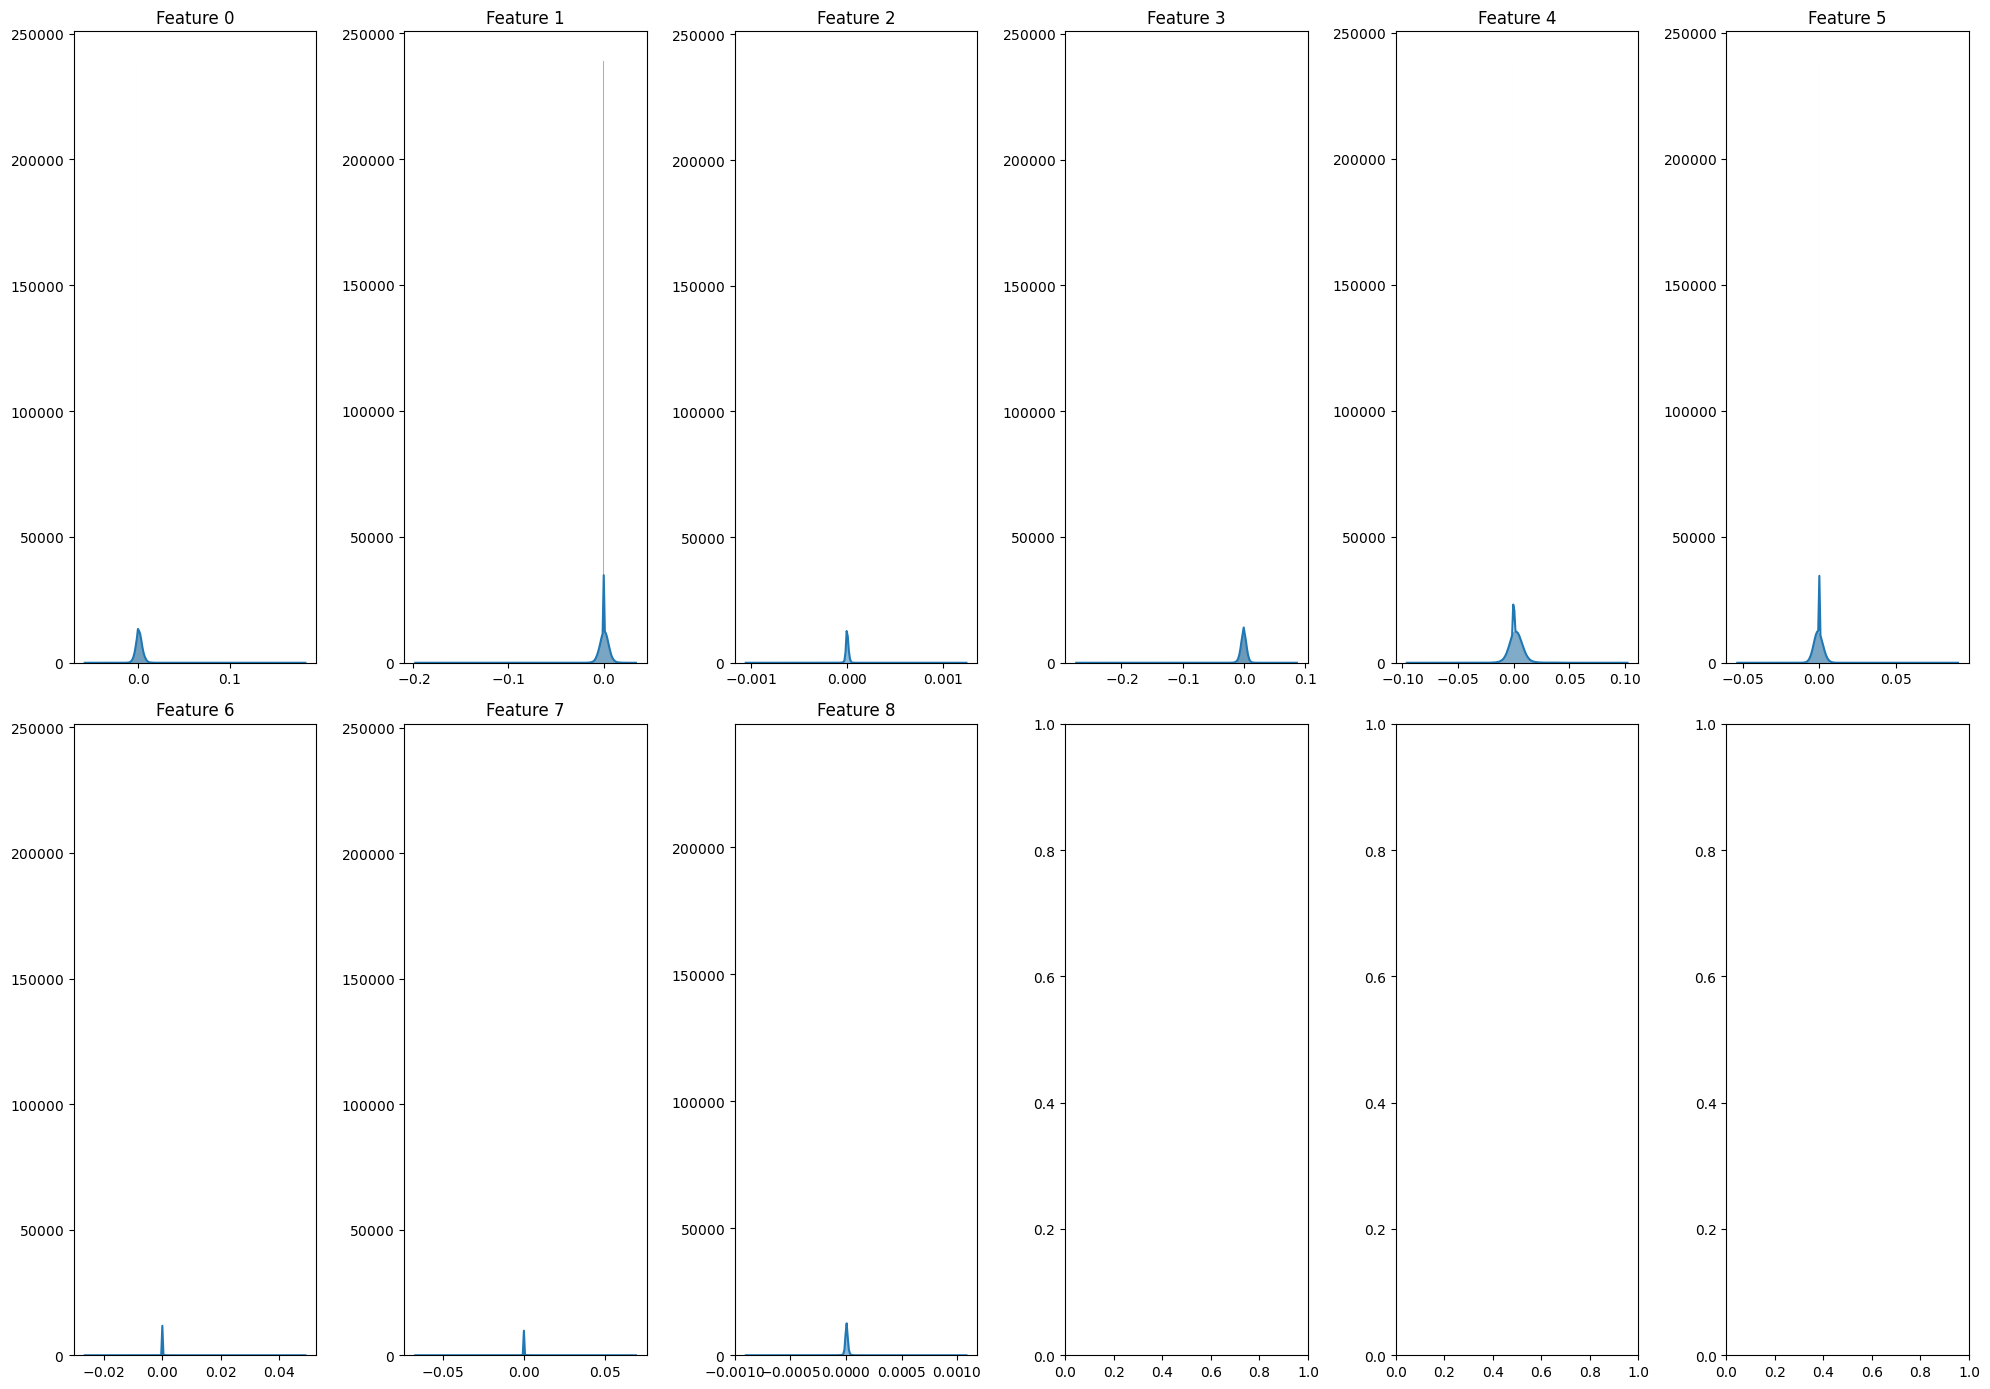

In [91]:
# print motion 1
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import pandas as pd
from tqdm import tqdm

latents_analysis = motion_latents
# latents_analysis = aligned_latents
latent_dim = len(latent_mask)

# Flatten the batch and length dimensions
flattened_motion = latents_analysis.view(-1, latents_analysis.shape[-1])

# Plot histograms for each feature
column_num = 6
fig, axes = plt.subplots(latent_dim // column_num + int(latent_dim % column_num != 0), column_num, figsize=(20, 14))
axes = axes.flatten()

for i, dim in tqdm(enumerate(latent_mask), total=len(latent_mask), desc="Plotting histograms"):
    print("Plotting feature: ", dim, ", index: ", i)
    sns.histplot(flattened_motion[:, dim].numpy(), ax=axes[i], kde=True)
    print("Plotted feature: ", dim, ", index: ", i)
    axes[i].set_title(f'Feature {dim}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axes[i].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.tight_layout()
plt.show()

# # Plot box plots for each feature
# plt.figure(figsize=(20, 6))
# sns.boxplot(data=flattened_motion.numpy())
# plt.title('Box Plot of Motion Features')
# plt.xlabel('Feature Index')
# plt.ylabel('Value')
# plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# plt.show()

### 2. Clamp at will

In [94]:
target = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
# 0-6 bound
# -0.05029296875, 0.0857086181640625, -0.07587742805480957, 0.058624267578125, -0.0004341602325439453, 0.00019466876983642578, 
#  -0.038482666015625, 0.0345458984375, -0.030120849609375, 0.038360595703125, -3.0279159545898438e-05, 1.3887882232666016e-05,
# 6-12 bound
# -0.0364990234375, 0.036102294921875, -0.043212890625, 0.046844482421875, -4.3332576751708984e-05, 1.8775463104248047e-05, 
# -0.03326416015625, 0.057373046875, -0.03460693359375, 0.031707763671875, -0.0001958608627319336, 0.0005192756652832031,
# 12-18 bound
# -0.0728759765625, 0.0587158203125, -0.04840087890625, 0.039642333984375, -0.00025916099548339844, 0.00048089027404785156, 
#  -0.09722900390625, 0.12469482421875, -0.1556396484375, 0.09326171875, -0.00018024444580078125, 0.00037860870361328125,
# 18-24 bound
# -0.0279384758323431, 0.010650634765625, -0.039306640625, 0.03802490234375, -1.049041748046875e-05, 3.6954879760742188e-06, 
#  -0.032989501953125, 0.044281005859375, -0.037261962890625, 0.0433349609375, -0.00022792529489379376, 0.0003247261047363281,
# 24-30 bound
# -0.0288234855979681, 0.006015777587890625, -0.0108795166015625, 0.0134124755859375, -7.784366607666016e-05, 5.2034854888916016e-05, 
#  -0.01531982421875, 0.027801513671875, -0.036041259765625, 0.0242156982421875, -8.83340835571289e-05, 2.6464462280273438e-05,
# 30-36 bound
# -0.06463623046875, 0.0303802490234375, -0.0446159653365612, 0.03619384765625, -0.02947998046875, 0.030792236328125, -0.0159145500510931, 
#  0.018890380859375, -0.01898193359375, 0.0264739990234375, -6.103515625e-05, 3.266334533691406e-05
# 36-42 bound
# -0.0094450069591403, 0.00604248046875, -0.005710510071367025, 0.00557708740234375, -2.866983413696289e-05, 1.4543533325195312e-05, 
#  -0.0265350341796875, 0.01186370849609375, -0.0227047111839056, 0.01386260986328125, -0.000133514404296875, 6.687641143798828e-05, 
# 42-48 bound
# -0.01129150390625, 0.01331329345703125, -0.0251922607421875, 0.0195465087890625, -8.285045623779297e-06, 6.079673767089844e-06, 
#  -0.0141599727794528, 0.018341064453125, -0.0189971923828125, 0.029296875, -6.049728108337149e-05, 3.057718276977539e-05, 
# 48-54 bound
# -0.01216888427734375, 0.02069091796875, -0.016754150390625, 0.017974853515625, -0.00014078617095947266, 6.842613220214844e-05, 
#  -0.01910400390625, 0.016204833984375, -0.025634765625, 0.04150390625, -0.0100250244140625, 0.00991058349609375, 
#  -0.005596160888671875, 0.01132965087890625, -0.0269775390625, 0.02166748046875, -0.000362396240234375, 9.059906005859375e-05,


In [95]:
# Pick a target, generate all_bounds
all_bounds = torch.zeros(len(latent_mask), 2)
for i in range(len(latent_mask)):
    quantiles = torch.quantile(motion_latents[:, :, latent_mask[i]], torch.tensor([target[i], 1-target[i]]))
    all_bounds[i] = quantiles
print(all_bounds)
print([tensor.item() for tensor in all_bounds.reshape(-1)])

tensor([[-1.2169e-02,  2.0691e-02],
        [-1.6754e-02,  1.7975e-02],
        [-1.4079e-04,  6.8426e-05],
        [-1.9104e-02,  1.6205e-02],
        [-2.5635e-02,  4.1504e-02],
        [-1.0025e-02,  9.9106e-03],
        [-5.5962e-03,  1.1330e-02],
        [-2.6978e-02,  2.1667e-02],
        [-3.6240e-04,  9.0599e-05]])
[-0.01216888427734375, 0.02069091796875, -0.016754150390625, 0.017974853515625, -0.00014078617095947266, 6.842613220214844e-05, -0.01910400390625, 0.016204833984375, -0.025634765625, 0.04150390625, -0.0100250244140625, 0.00991058349609375, -0.005596160888671875, 0.01132965087890625, -0.0269775390625, 0.02166748046875, -0.000362396240234375, 9.059906005859375e-05]


In [96]:
# Get all items in bounds if neede to ( deprecated )


# all_in_bound = torch.ones(motion_latents.shape[0], motion_latents.shape[1], dtype=torch.bool)
# for i in range(len(latent_mask)):
#     all_in_bound &= (motion_latents[:, :, i] >= all_bounds[i][0]) & (motion_latents[:, :, i] <= all_bounds[i][1])

# print(all_in_bound.shape)
# print(all_in_bound.sum())
# print(motion_latents.shape[0] * motion_latents.shape[1])

# # Count the number of entries in dim 0 its entries in dim 1 and 2 are all ones
# entries_in_bound_dim0 = all_in_bound.all(dim=1).sum()
# print(entries_in_bound_dim0)

# Count how many of the last dim is full of zeros and drop them
# clamped_motion_latents = clamped_motion_latents.reshape(-1, clamped_motion_latents.shape[-1])
# non_zero_mask = ~(clamped_motion_latents == 0).all(dim=-1)
# clamped_motion_latents = clamped_motion_latents[non_zero_mask]

# # Count the number of dropped vectors
# dropped_count = (~non_zero_mask).sum().item()
# print(f"Number of vectors dropped (all zeros in last dimension): {dropped_count}")

# # Display the original and new shapes for reference
# print(f"Original shape: {clamped_motion_latents.shape[0] + dropped_count, clamped_motion_latents.shape[1]}")
# print(f"New shape after dropping zero vectors: {clamped_motion_latents.shape}")


In [97]:
# Clamp motion tensor to boundary
clamped_motion_latents = torch.zeros_like(motion_latents)

for i in range(len(latent_mask)):
    lower_bound = all_bounds[i][0]
    upper_bound = all_bounds[i][1]
    clamped_motion_latents[:, :, latent_mask[i]] = torch.clamp(motion_latents[:, :, latent_mask[i]], min=lower_bound, max=upper_bound)

In [98]:
# print audio latents analysis ( deprecated )
'''
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

latents_analysis = audio_latents[:, :, :]
latent_dim = latents_analysis.shape[-1]

# Flatten the batch and length dimensions
flattened_motion = latents_analysis.view(-1, latent_dim)

# Calculate basic statistics
mean = flattened_motion.mean(dim=0)
std = flattened_motion.std(dim=0)
min_vals = flattened_motion.min(dim=0).values
max_vals = flattened_motion.max(dim=0).values

# Calculate absolute magnitude statistics
abs_flattened_motion = flattened_motion.abs()
abs_mean = abs_flattened_motion.mean(dim=0)
abs_std = abs_flattened_motion.std(dim=0)
abs_min_vals = abs_flattened_motion.min(dim=0).values
abs_max_vals = abs_flattened_motion.max(dim=0).values

# Create a summary dataframe
summary = pd.DataFrame({
    'Mean': mean.numpy(),
    'Std': std.numpy(),
    'Min': min_vals.numpy(),
    'Max': max_vals.numpy(),
    'Abs Mean': abs_mean.numpy(),
    'Abs Std': abs_std.numpy(),
    'Abs Min': abs_min_vals.numpy(),
    'Abs Max': abs_max_vals.numpy()
})

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Print the full summary
print(summary.to_string())

# # Plot histograms for each feature
# fig, axes = plt.subplots(latent_dim // 10 + int(latent_dim % 10 != 0), 10, figsize=(20, 14))
# axes = axes.flatten()

# for i in tqdm(range(latent_dim), desc="Plotting histograms"):
#     sns.histplot(flattened_motion[:, i].numpy(), ax=axes[i], kde=True)
#     axes[i].set_title(f'Feature {i}')
#     axes[i].set_xlabel('')
#     axes[i].set_ylabel('')
#     axes[i].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#     axes[i].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

# plt.tight_layout()
# plt.show()

# # Plot box plots for each feature
# plt.figure(figsize=(20, 6))
# sns.boxplot(data=flattened_motion.numpy())
# plt.title('Box Plot of Motion Features')
# plt.xlabel('Feature Index')
# plt.ylabel('Value')
# plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# plt.show()
'''

'\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport pandas as pd\n\nlatents_analysis = audio_latents[:, :, :]\nlatent_dim = latents_analysis.shape[-1]\n\n# Flatten the batch and length dimensions\nflattened_motion = latents_analysis.view(-1, latent_dim)\n\n# Calculate basic statistics\nmean = flattened_motion.mean(dim=0)\nstd = flattened_motion.std(dim=0)\nmin_vals = flattened_motion.min(dim=0).values\nmax_vals = flattened_motion.max(dim=0).values\n\n# Calculate absolute magnitude statistics\nabs_flattened_motion = flattened_motion.abs()\nabs_mean = abs_flattened_motion.mean(dim=0)\nabs_std = abs_flattened_motion.std(dim=0)\nabs_min_vals = abs_flattened_motion.min(dim=0).values\nabs_max_vals = abs_flattened_motion.max(dim=0).values\n\n# Create a summary dataframe\nsummary = pd.DataFrame({\n    \'Mean\': mean.numpy(),\n    \'Std\': std.numpy(),\n    \'Min\': min_vals.numpy(),\n    \'Max\': max_vals.numpy(),\n    \'Abs Mean\': abs_mean.numpy(),\n    \'Abs Std\': abs_std.num

In [99]:
clamped_motion_latents.shape

torch.Size([25707, 75, 9])

torch.Size([1928025, 9])


Plotting histograms: 100%|██████████| 9/9 [00:39<00:00,  4.41s/it]


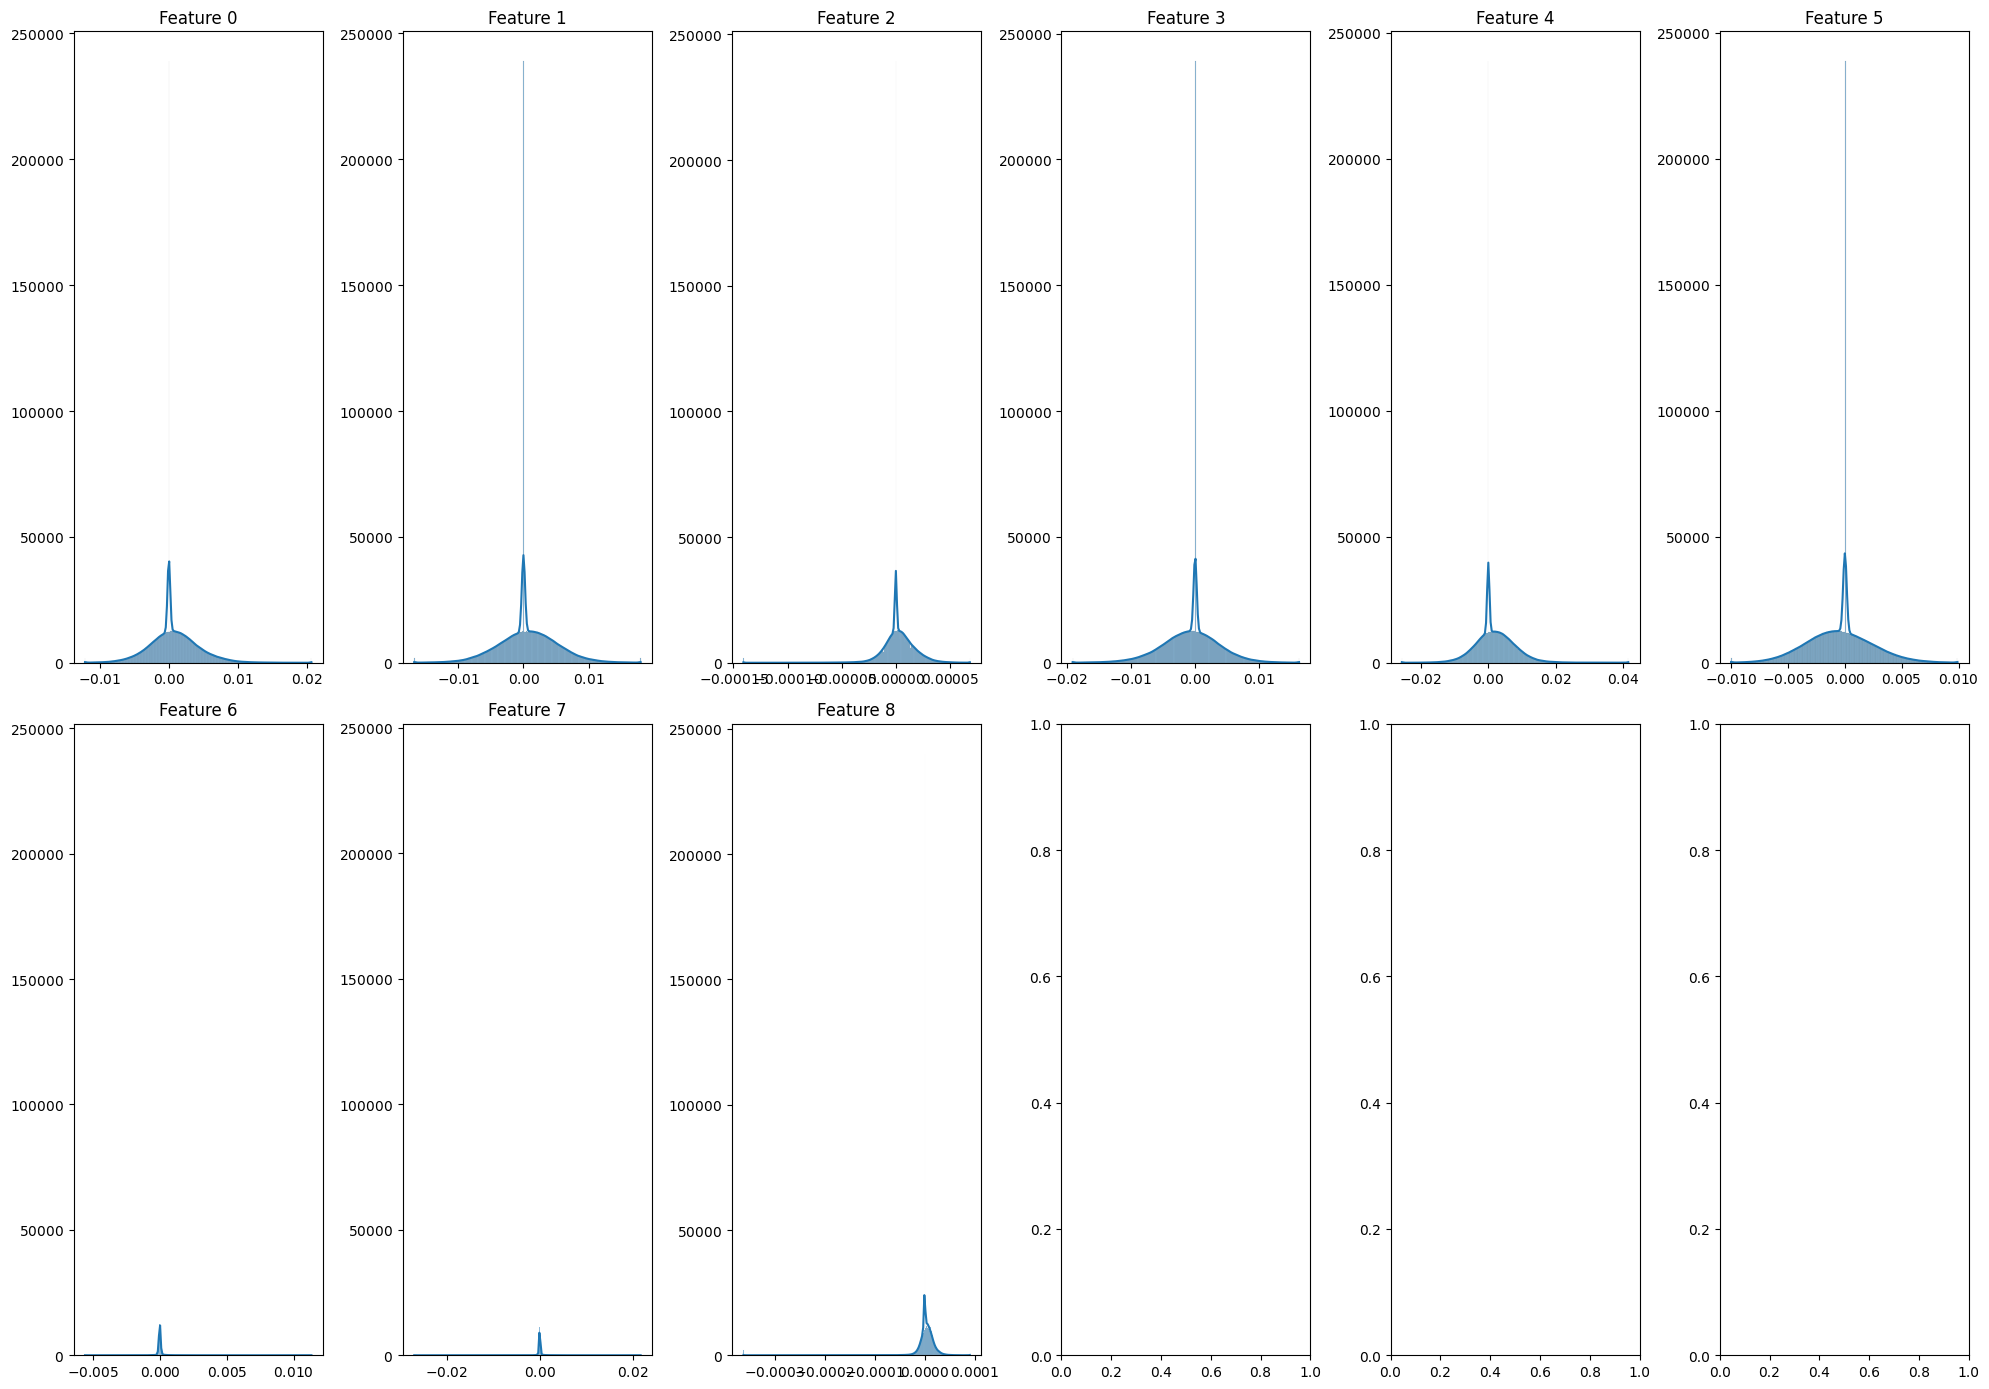

In [100]:
# print motion 1
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import pandas as pd
from tqdm import tqdm

latents_analysis = clamped_motion_latents
# latents_analysis = aligned_latents
latent_dim = len(latent_mask)

# Flatten the batch and length dimensions
flattened_motion = latents_analysis.view(-1, latents_analysis.shape[-1])
print(flattened_motion.shape)
# # Calculate basic statistics
# mean = flattened_motion.mean(dim=0)
# std = flattened_motion.std(dim=0)
# min_vals = flattened_motion.min(dim=0).values
# max_vals = flattened_motion.max(dim=0).values

# # Calculate absolute magnitude statistics
# abs_flattened_motion = flattened_motion.abs()
# abs_mean = abs_flattened_motion.mean(dim=0)
# abs_std = abs_flattened_motion.std(dim=0)
# abs_min_vals = abs_flattened_motion.min(dim=0).values
# abs_max_vals = abs_flattened_motion.max(dim=0).values

# # Create a summary dataframe
# summary = pd.DataFrame({
#     'Mean': mean.numpy(),
#     'Std': std.numpy(),
#     'Min': min_vals.numpy(),
#     'Max': max_vals.numpy(),
#     'Abs Mean': abs_mean.numpy(),
#     'Abs Std': abs_std.numpy(),
#     'Abs Min': abs_min_vals.numpy(),
#     'Abs Max': abs_max_vals.numpy()
# })

# # Set display options to show all rows and columns
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

# # Print the full summary
# print(summary.to_string())

# Plot histograms for each feature
column_num = 6
fig, axes = plt.subplots(latent_dim // column_num + int(latent_dim % column_num != 0), column_num, figsize=(20, 14))
axes = axes.flatten()

for i, dim in tqdm(enumerate(latent_mask), total=len(latent_mask), desc="Plotting histograms"):
    sns.histplot(flattened_motion[:, dim].numpy(), ax=axes[i], kde=True)
    axes[i].set_title(f'Feature {dim}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axes[i].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.tight_layout()
plt.show()

# # Plot box plots for each feature
# plt.figure(figsize=(20, 6))
# sns.boxplot(data=flattened_motion.numpy())
# plt.title('Box Plot of Motion Features')
# plt.xlabel('Feature Index')
# plt.ylabel('Value')
# plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# plt.show()

### 3. Deprecated Hard scaling. Likely Won't need.


In [101]:
# Break execution
1 = 1

SyntaxError: cannot assign to literal here. Maybe you meant '==' instead of '='? (3220323381.py, line 2)

In [ ]:
import numpy as np
import torch

# Assuming abs_std is already defined
# abs_std = torch.randn(70)  # Example tensor, replace with your actual tensor

# Define the bins in logarithmic scale from 1e-1 to 1e-8
bins = np.logspace(-1, -8, num=8)

# Digitize the abs_std values into the defined bins
bin_indices = np.digitize(abs_std[:63].numpy(), bins)

# Create a list to store indices for each bin
bin_index_lists = [[] for _ in range(len(bins) + 1)]

# Populate the bin_index_lists
for idx, bin_idx in enumerate(bin_indices):
    bin_index_lists[bin_idx].append(idx)

# Print the bin counts and indices
bin_counts = np.bincount(bin_indices, minlength=len(bins) + 1)
for i, (count, indices) in enumerate(zip(bin_counts, bin_index_lists)):
    if i == 0:
        print(f"< {bins[0]:.1e}: {count}")
    elif i == len(bins):
        print(f">= {bins[-1]:.1e}: {count}")
    else:
        print(f"{bins[i-1]:.1e} - {bins[i]:.1e}: {count}")
    print(f"Indices: {indices}")
    print()

In [ ]:
latents_analysis = motion_latents
latent_dim = latents_analysis.shape[-1]

# Flatten the batch and length dimensions
flattened_motion = latents_analysis.view(-1, latent_dim)

flattened_motion.shape

In [ ]:
def normalize_features(features):
    # Step 1: Standardize (mean=0, std=1)
    mean = features.mean(dim=0, keepdim=True)
    std = features.std(dim=0, keepdim=True)
    standardized = (features - mean) / (std + 1e-8)
    
    # Step 2: Min-max scaling to [0, 1]
    # min_vals = standardized.min(dim=0, keepdim=True)[0]
    # max_vals = standardized.max(dim=0, keepdim=True)[0]
    # normalized = (standardized - min_vals) / (max_vals - min_vals + 1e-8)
    
    return standardized

flattened_motion = normalize_features(flattened_motion)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

latents_analysis = motion_latents

# Flatten the batch and length dimensions
flattened_motion = latents_analysis.view(-1, latent_dim)
flattened_motion = flattened_motion[:, :63]
latent_dim = flattened_motion.shape[-1]
# Calculate basic statistics
mean = flattened_motion.mean(dim=0)
std = flattened_motion.std(dim=0)
min_vals = flattened_motion.min(dim=0).values
max_vals = flattened_motion.max(dim=0).values

# Create a summary dataframe
import pandas as pd
summary = pd.DataFrame({
    'Mean': mean.numpy(),
    'Std': std.numpy(),
    'Min': min_vals.numpy(),
    'Max': max_vals.numpy()
})

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Print the full summary
print(summary.to_string())

# Plot histograms for each feature
fig, axes = plt.subplots(latent_dim // 10 + int(latent_dim % 10!=0), 10, figsize=(20, 14))
axes = axes.flatten()

from tqdm import tqdm
for i in tqdm(range(latent_dim), desc="Plotting histograms"):
    sns.histplot(flattened_motion[:, i].numpy(), ax=axes[i], kde=True)
    axes[i].set_title(f'Feature {i}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

# Plot box plots for each feature
plt.figure(figsize=(20, 6))
sns.boxplot(data=flattened_motion.numpy())
plt.title('Box Plot of Motion Features')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.show()

In [ ]:
y=flattened_motion[:, 24]

In [ ]:
import numpy as np

def count_distribution(y, bins):
    pos_bins = np.array(bins)
    neg_bins = -pos_bins[::-1]
    all_bins = np.concatenate([neg_bins, [0], pos_bins])
    
    counts, _ = np.histogram(y, bins=all_bins)
    
    bin_labels = [f"-{b}" for b in bins[::-1]] + ["0"] + [f"+{b}" for b in bins]
    
    for label, count in zip(bin_labels, counts):
        print(f"{label}: {count}")

    return counts, bin_labels

# Define the bins
bins = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20]

# Get the data for feature 24
y = flattened_motion[:, 24].numpy()

# Count the distribution
counts, labels = count_distribution(y, bins)

# Optionally, you can plot the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(labels, counts)
plt.title('Distribution of Feature 24')
plt.xlabel('Bins')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Plot feature 24
plt.figure(figsize=(12, 6))
sns.histplot(flattened_motion[:, 24].numpy(), kde=True)
plt.title('Distribution of Feature 24')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Box plot for feature 24
plt.figure(figsize=(8, 6))
sns.boxplot(y=flattened_motion[:, 24].numpy())
plt.title('Box Plot of Feature 24')
plt.ylabel('Value')
plt.show()

# Print summary statistics for feature 24
feature_24_summary = summary.iloc[24]
print("Summary statistics for Feature 24:")
print(feature_24_summary)


In [ ]:
def normalize_features(features):
    mean = features.mean(dim=0, keepdim=True)
    std = features.std(dim=0, keepdim=True)
    return (features - mean) / (std + 1e-8)  # Add small epsilon to avoid division by zero

normalized_features = normalize_features(all_coefs['shape'])

In [ ]:
import pandas as pd
import numpy as np
import torch

# Set display options to show all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Calculate statistics
mean = flattened_motion.mean(dim=0)
std = flattened_motion.std(dim=0)
min_vals = flattened_motion.min(dim=0).values
max_vals = flattened_motion.max(dim=0).values
median = flattened_motion.median(dim=0).values  # Use .values to get the tensor
percentile_25 = torch.quantile(flattened_motion, 0.25, dim=0)
percentile_75 = torch.quantile(flattened_motion, 0.75, dim=0)

# Create the summary DataFrame
summary = pd.DataFrame({
    'Mean': mean.numpy(),
    'Std': std.numpy(),
    'Min': min_vals.numpy(),
    '25%': percentile_25.numpy(),
    'Median': median.numpy(),
    '75%': percentile_75.numpy(),
    'Max': max_vals.numpy()
})

# Print the full summary
print(summary)

# Reset display options to default (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

In [ ]:
import lmdb
import numpy as np
import os
import pickle
import torch
from tqdm import tqdm

# Specify the directory containing the LMDB file
lmdb_dir = '/mnt/e/data/diffposetalk_data/HDTF_TFHP-lmdb/'

# Check if the directory exists and contains the necessary files
if not os.path.isdir(lmdb_dir):
    print(f"The directory {lmdb_dir} does not exist.")
elif not os.path.isfile(os.path.join(lmdb_dir, 'data.mdb')):
    print(f"The data file 'data.mdb' is missing from {lmdb_dir}")
elif not os.path.isfile(os.path.join(lmdb_dir, 'lock.mdb')):
    print(f"The lock file 'lock.mdb' is missing from {lmdb_dir}")
else:
    print(f"Found LMDB environment in: {lmdb_dir}")

    # Try to open the LMDB environment
    # try:
    env = lmdb.open(lmdb_dir, readonly=True, lock=False)
    
    # Start a new read transaction
    with env.begin(write=False) as txn:
        # Get the number of keys in the database
        num_keys = txn.stat()['entries']
        print(f"Number of entries in the database: {num_keys}")

        # Read all entries
        all_data = []
        cursor = txn.cursor()
        for key, value in tqdm(cursor, total=num_keys, desc="Reading LMDB"):
            if key == b'metadata':
                metadata = pickle.loads(value)
                print("Metadata:", metadata)
            else:
                entry = pickle.loads(value)
                all_data.append(entry)



In [ ]:
key_count = {}
for entry in all_data:
    keys = tuple(entry.keys())  # Convert keys to tuple so it can be used as a dictionary key
    if keys in key_count:
        key_count[keys] += 1
    else:
        key_count[keys] = 1

# Print the results
for keys, count in key_count.items():
    print(f"Keys: {keys}, Count: {count}")

In [ ]:
# Process the data
coef_keys = ['shape', 'exp', 'pose']
all_coefs = {k: [] for k in coef_keys}
all_audio = []

for entry in all_data:
    if 'coef' in entry.keys():
        for k in coef_keys:
            all_coefs[k].append(entry['coef'][k])
    # Uncomment the following line if you want to process audio data
    # all_audio.append(torch.from_numpy(np.frombuffer(entry['audio'], dtype=np.float32)))

# Convert to tensors and stack arrays with shape[0] == 100
for k in coef_keys:
    valid_coefs = [coef for coef in all_coefs[k] if coef.shape[0] == 100]
    if valid_coefs:
        all_coefs[k] = np.stack(valid_coefs, axis=0)
        all_coefs[k] = torch.from_numpy(all_coefs[k])
    else:
        print(f"Warning: No valid coefficients found for {k}")
        all_coefs[k] = None

# Print shapes
print("\nData shapes:")
for k in coef_keys:
    if all_coefs[k] is not None:
        print(f"{k} shape: {all_coefs[k].shape}")
    else:
        print(f"{k}: No valid data")

# Calculate and print statistics
print("\nCoefficient statistics:")
for k in coef_keys:
    if all_coefs[k] is not None:
        print(f"\n{k}:")
        print(f"  Mean: {all_coefs[k].mean().item():.4f}")
        print(f"  Std: {all_coefs[k].std().item():.4f}")
        print(f"  Min: {all_coefs[k].min().item():.4f}")
        print(f"  Max: {all_coefs[k].max().item():.4f}")
    else:
        print(f"\n{k}: No valid data for statistics")

# Uncomment the following lines if you want to process audio data
# all_audio = torch.cat(all_audio, dim=0)
# print("\nAudio shape:", all_audio.shape)
# print("\nAudio statistics:")
# print(f"  Mean: {all_audio.mean().item():.4f}")
# print(f"  Std: {all_audio.std().item():.4f}")
# print(f"  Min: {all_audio.min().item():.4f}")
# print(f"  Max: {all_audio.max().item():.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plots for all three coefficients
for coef_key in ['exp', 'shape', 'pose']:
    if all_coefs[coef_key] is not None:
        coef_data = all_coefs[coef_key]
        num_features = coef_data.shape[-1]
        
        # Calculate grid dimensions
        grid_rows = int(np.ceil(np.sqrt(num_features)))
        grid_cols = int(np.ceil(num_features / grid_rows))
        
        plt.figure(figsize=(20, 15))
        
        for feat_idx in range(num_features):
            # Extract the current feature dimension
            feature = coef_data[..., feat_idx].flatten()
            
            # Create a subplot for each feature
            plt.subplot(grid_rows, grid_cols, feat_idx + 1)
            
            # Plot the histogram
            plt.hist(feature.numpy(), bins=50, edgecolor='black')
            
            # Set title and labels
            plt.title(f'{coef_key.capitalize()} Feature {feat_idx + 1}')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            
            # Add some statistics to the plot
            plt.text(0.05, 0.95, f'Mean: {feature.mean():.4f}\nStd: {feature.std():.4f}', 
                     transform=plt.gca().transAxes, verticalalignment='top', fontsize=8)

        # Adjust the layout and display the plot
        plt.suptitle(f'Histogram of {coef_key.capitalize()} Coefficient Features', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print(f"No valid data for '{coef_key}' coefficient")
